In [49]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import linear_model
from sklearn import metrics
from statsmodels.graphics.api import qqplot

In [2]:
print(sm.datasets.sunspots.NOTE)

::

    Number of Observations - 309 (Annual 1700 - 2008)
    Number of Variables - 1
    Variable name definitions::

        SUNACTIVITY - Number of sunspots for each year

    The data file contains a 'YEAR' variable that is not returned by load.



In [3]:
data = sm.datasets.sunspots.load_pandas().data

In [4]:
data.index = pd.Index(sm.tsa.datetools.dates_from_range('1700', '2008'))
del data['YEAR']

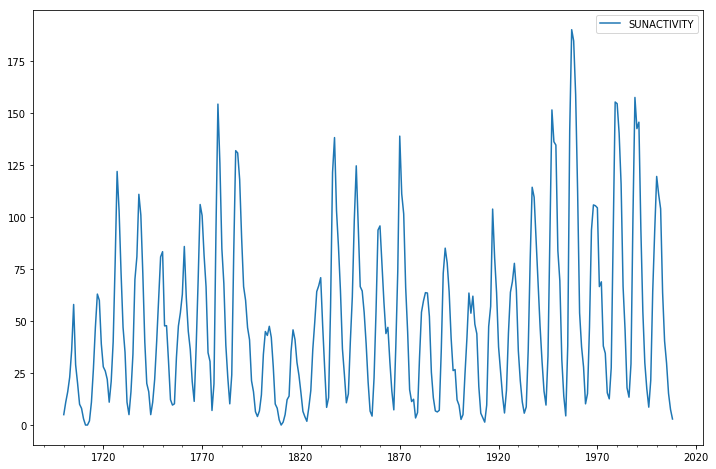

In [5]:
data.plot(figsize=(12, 8))

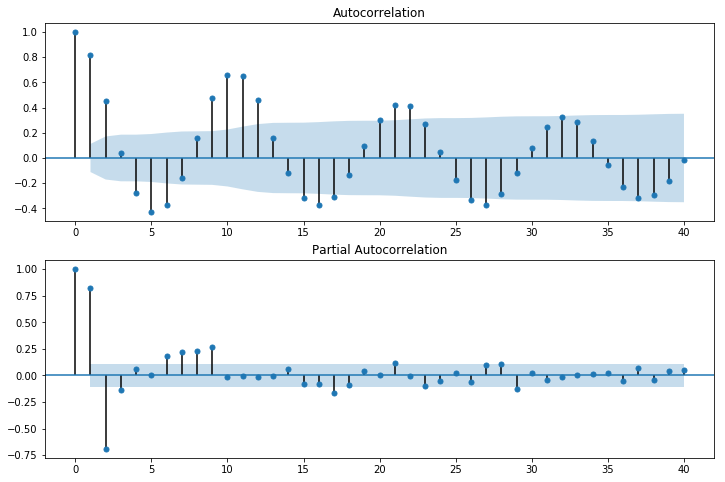

In [6]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data.values.squeeze(), lags=40, ax=ax)
ax = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data.values.squeeze(), lags=40, ax=ax)

# Autocorrelation

Let's look how autocorrelation is defined. First we make a function that computes the Pearson correlation between two sequences that are assumed to come from a Normal distribution.

In [7]:
x = data.values.squeeze()

In [8]:
def pearson_correlation(x, y):
    return np.mean((x - x.mean()) * (y - y.mean())) / (x.std() * y.std())
    
pearson_correlation(x, x + np.random.randn(x.shape[0]))

0.999687011702813

The autocorrelation is the correlation between the sequence with the current last value truncated at the end `x[:-1]` and the sequence with a certain amount of lag `x[:i]`.

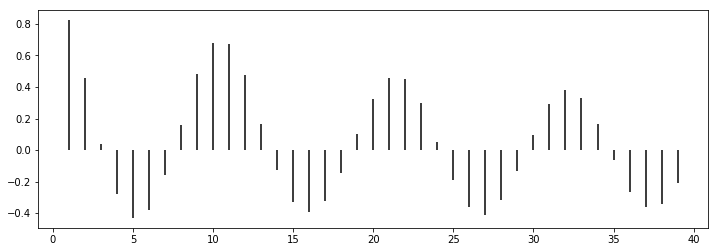

In [9]:
def plot(x, lag=40):
    plt.figure(figsize=(12, 4))
    corr = [pearson_correlation(x[:-i], x[i:]) for i in range(1, lag)]
    plt.vlines(np.arange(1, lag), 0, corr)
    plt.show()
plot(x)

# Moveing average model MA(q)

$$ X_t = \mu + \epsilon_t + \theta_1 \epsilon_{t-1} ... + \theta_q \epsilon_{q} $$

where $\epsilon$ is white noise:

$$\epsilon \sim N(0, \alpha)$$

$\alpha$ is standard deviation of the sequence?


54.39517901679693
4833.691033366038


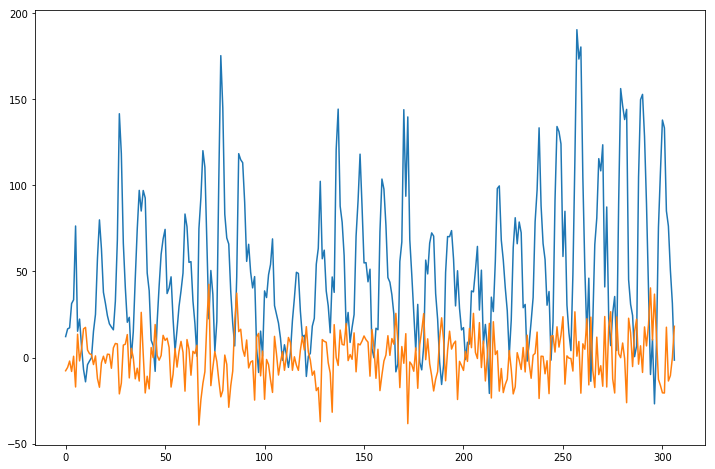

In [249]:
def init_eps(order, y, sigma=None):
    sigma = y.std() / 3 if sigma is None else sigma
    return np.random.normal(0, sigma, size=(y.shape[0]))


def create_ma_features(eps, y, order):
    eps = np.array([eps[-(i + order):][:order][::-1] for i in range(y.shape[0])])
    y = y[:-order]
    eps = eps[:-order]
    eps = np.stack(eps)
    return eps, y

    

def ma_model(y, order=2, plot=False, intercept=False, eps=None):
    """
    When combined with AR model intercept should be false as that model provides one.
    """
    y = y.copy()
    mu = 0 #y.mean()
    
    # create a sequence of random error values.
    eps = init_eps(order, y) if eps is None else eps
    
    # create features by shifting the window of `order` size by one step.
    eps, y = create_ma_features(eps, y, order)

    # move mu and epsilon_1 to the left side of the equation.

    # This should be added to the final regression output
    add = eps[:, 0] + mu

    y -= add
    eps = np.delete(eps, 0, axis=1)
    m = linear_model.LinearRegression(fit_intercept=intercept)
    m.fit(eps, y)
    pred = m.predict(eps) + add
    
    if plot:
        print(metrics.mean_absolute_error(y, pred))
        print(metrics.mean_squared_error(y, pred))

        plt.figure(figsize=(12, 8))
        plt.plot(np.arange(0, y.shape[0]), y)
        plt.plot(np.arange(0, y.shape[0]), pred)

        plt.show()
    return pred, m
    
_ = ma_model(x, 2, True, intercept=False)


# Autoregressive model

$$ X_t = c + \epsilon_t + \theta_1 X_{t-1} ... + \theta_p X_{q} $$

where $\epsilon$ is white noise:

$$\epsilon \sim N(0, \alpha)$$

$\alpha$ is standard deviation of the sequence?

$$X_t = c + \epsilon_t + \sum_{i=1}^{p}{\phi_i X_{t - i}} + \sum_{i = 1}^q{\theta_i \epsilon_{t-i}} $$

16.94434518547299 [-0.13025039 -0.50994881  1.30172139]


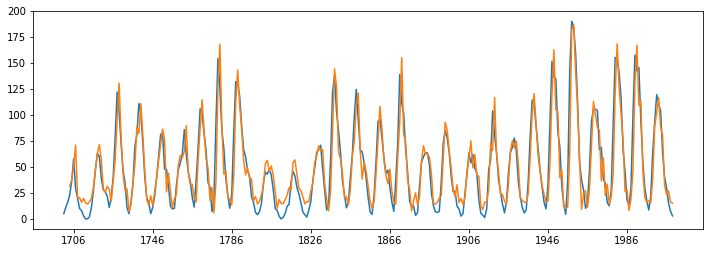

In [355]:
def create_ra_features(x, order):
    y = x.copy()
    # create features by shifting the window of `order` size by one step.
    x = np.array([y[-(i + order):][:order] for i in range(y.shape[0])])
    
    # make sure that we end with even array so that the stack operation succeeds
    x = np.stack(x)[::-1][order - 1: -1]
    y = y[order:]
    
    return x, y

def create_ma_features(eps, y, order):
    eps = np.array([eps[-(i + order):][:order] for i in range(y.shape[0])])
    eps = np.stack(eps)[::-1][order - 1:]
    # eps_t is known when predicting x_t so the labels are in the same phase /lag
    # as the features eps.
    y = y[order - 1:]    
    return eps, y


# https://en.wikipedia.org/wiki/Autoregressive%E2%80%93moving-average_model 
def ra_model(y, eps, order=2):
    x, y = create_ra_features(y)    
    
    # Move eps_t to other side of equation
    add = eps[:y.shape[0]]
    y -= add
    
    m = linear_model.LinearRegression(fit_intercept=True)
    m.fit(x, y)
    
    return m.predict(x) + add, m


class ARMA:
    def __init__(self, p, q, sigma=None):
        self.p = p
        self.q = q
        self.MA = None
        self.RA = None
        self.m = None
        self.sigma = sigma
        
    def prepare_features(self, x):
        eps = init_eps(self.q, x)
        
        # create features by shifting the window of `order` size by one step.
        x_ = None
        ma_features = ra_features = np.zeros((x.shape[0], 1))
        if self.q > 1:
            ma_features, x_ = create_ma_features(eps, x, self.q + 1)
        if self.p > 0:
            ra_features, x = create_ra_features(x, self.p)
        x = x if x_ is None or len(x) < len(x_) else x_
        del x_
            
        eps = eps[:x.shape[0]]
        ma_features = ma_features[:x.shape[0]]
        ra_features = ra_features[:x.shape[0]]
        eps_t = ma_features[:, :1]
        ma_features = ma_features[:, 1:]
        return np.hstack((ma_features, ra_features)), eps_t.ravel(), x
        
    def fit_predict(self, x):        
        # move eps_t to left side of the equation
        
        features, eps_t, x = self.prepare_features(x)

        x = x - eps_t
        model = linear_model.LinearRegression(fit_intercept=True)
        model.fit(features, x)
        self.m = model
        
        return model.predict(features) + eps_t
        
        
q = 0
p = 3

m = ARMA(p, q, sigma=1)
pred = m.fit_predict(x)
print(m.m.intercept_, m.m.coef_)
# print(m.RA.intercept_)
# m.RA.coef_

plt.figure(figsize=(12,4))
plt.plot(data)
plt.plot(data.index[data.shape[0] - pred.shape[0]:], pred)

/opt/miniconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  % freq, ValueWarning)
/opt/miniconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/opt/miniconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/opt/miniconda3/lib/python3.6/site-packages/scipy/sign

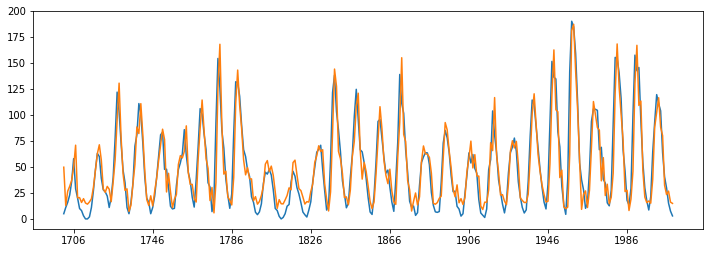

In [354]:
p = 3
q = 0
m = sm.tsa.ARMA(data.copy(), (p, q)).fit()
plt.figure(figsize=(12,4))
plt.plot(data)
plt.plot(data.index, m.model.predict(m.params, '1700', '2008'))

/opt/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


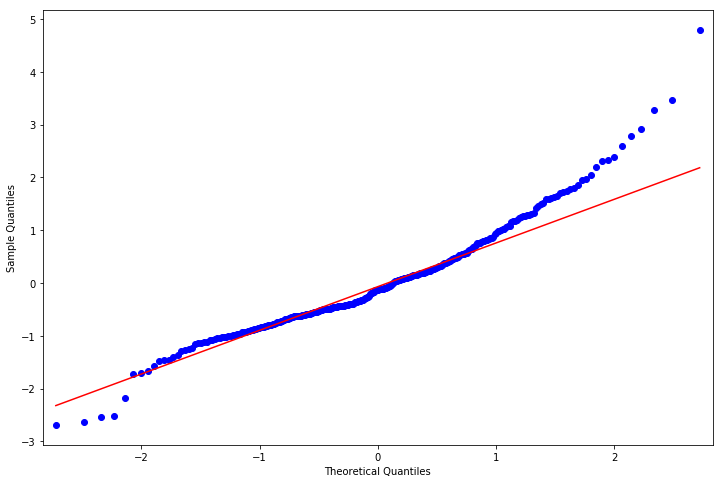

In [50]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
fig = qqplot(m.resid, line='q', ax=ax, fit=True)


In [ ]:
m.resid